In [ ]:
# default_exp multiscale_flow_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 05c Multiscale Flow Embeddings with a Grid
The problem with the Diffusion Flow Embedder (05b) is that, although it minimizes the loss quite well, achieving 0 cost only requires the network to replicate the graph's *affinity* matrix within the embedding. Consequently, the embedding only preserves near neighbors; like tSNE, it willfully distorts global structure.

This manifests in, for example 05b05 and 05b05a, where we see that the spiral (and the swiss roll) are not *unrolled*, as we'd like -- but are either left coiled, as in their projections, or wrapped oddly. The affinity matrices of the embeddings are beautiful. They have no way of telling how weird the global structure is. 

As a result, the flows learnt by the method are unnecessarily complex, and tend to wrap around the manifold. The flows are only used for near neighbor connectivity, hence there is no incentive to learn anything that makes sense in long ranges.

This notebook is motivated by a suspicion that these effects can be greatly lessened with two novel additions:
1. *multiscale* diffusion probability comparisons  -- between $P_{graph}^t$ and $P_{embedding}^t$ for several values of $t$, but only in which
2. a *grid* connects points in the embedding space in a way the ambient points aren't connected.

Much of the machinery for this was already developed in 05b. We need only introduce the grid, and a multiscale loss.

I'm additionally going to try to make the class as *modular* as possible, to avoid the syndrome of doing everything within one giant code block with a class that has dozens of functions.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, smoothness_of_vector_field
def compute_grid(X,grid_width=20):
  """ Returns a grid of points which bounds the points X. 
  The grid has 'grid_width' dots in both length and width.
  Accepts X, tensor of shape n x 2
  Returns tensor of shape grid_width^2 x 2"""
  # TODO: This currently only supports 
  # find support of points
  minx = (min(X[:,0])-1).detach()
  maxx = (max(X[:,0])+1).detach()
  miny = (min(X[:,1])-1).detach()
  maxy = (max(X[:,1])+1).detach()
  # form grid around points
  x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
  xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
  xy_t = xy_t.reshape(grid_width**2,2)
  return xy_t

A cornerstone of this method will be the powering of the diffusion matrix, which must intersperse jumping between points in the dataset and in the surrounding grid. Traditional matrix powering will do, provided we add the grid points to the dataset before powering, and then take them out afterwards.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, GaussianVectorField
import torch.nn.functional as F
def diffusion_matrix_with_grid_points(X, grid, flow_function, t, sigma,flow_strength):
  n_points = X.shape[0]
  # combine the points and the grid
  points_and_grid = torch.concat([X,grid],dim=0)
  # get flows at each point
  flow_per_point = flow_function(points_and_grid)
  # take a diffusion matrix
  A = affinity_matrix_from_pointset_to_pointset(points_and_grid,points_and_grid, flows = flow_per_point, sigma = sigma, flow_strength=flow_strength)
  P = torch.diag(1/A.sum(1)) @ A # TODO: is there a more efficient way to do this?
  # TODO: Should we remove self affinities? Probably not, as lazy random walks are advantageous when powering
  # Power the matrix to t steps
  Pt = torch.matrix_power(P,t)
  # Recover the transition probabilities between the points, and renormalize them
  P_points = P[:n_points,:n_points]
  P_points = torch.diag(1/P_points.sum(1)) @ P_points
  # return diffusion probs between points
  return P_points

In [ ]:
A = torch.tensor([[1,2],[3,4],[5,6]])
B = torch.rand(5,2)
K = GaussianVectorField(2,25,device)
out = diffusion_matrix_with_grid_points(A,B,K,1, 0.5, 4)
out

tensor([[9.9658e-01, 3.4106e-03, 1.1915e-05],
        [2.8935e-04, 9.6078e-01, 3.8935e-02],
        [1.2119e-05, 3.4690e-03, 9.9652e-01]], grad_fn=<MmBackward0>)

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import GaussianVectorField, smoothness_of_vector_field
class MultiscaleDiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, 
							X, 
							flows, 
							ts = [1,2,4,8], 
							sigma_graph = 0.5, 
							sigma_embedding=0.5, 
							flow_strength_graph=5, 
							flow_strength_embedding=5, 
							embedding_dimension=2, 
							device=torch.device('cpu'), 
							autoencoder_shape = [4,8,4], 
							flow_artist = "gaussian",
							flow_artist_shape = [4,8,4], 
							learning_rate = 1e-5,
							num_gaussians = 25,
							labels = None,    
							loss_weights = {
								"diffusion":0.7,
								"smoothness":0.2,
								"reconstruction":0.1
							}  
							):
		# initialize parameters
		super(MultiscaleDiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.ts = ts
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		
		self.eps = 0.001
		self.loss_weights = loss_weights
		self.labels = labels
		self.flow_strength = nn.Parameter(torch.tensor(flow_strength_embedding).float())
		self.embedding_dimension = embedding_dimension
		# set device (used for shuffling points around during visualization)
		self.device = device
		# Used for 
		self.losses = {}
		for k in self.loss_weights.keys():
			self.losses[k] = []
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=flow_strength_graph)
		self.P_graph = torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
		# compute matrix powers 
		# TODO: Could reuse previous powers to speed this up
		self.P_graph_ts = [torch.matrix_power(self.P_graph,t) for t in self.ts]
		self.P_embedding_ts = [None for i in self.ts]
		# Flow field
		# Gaussian model
		if flow_artist == "gaussian":
			self.FlowArtist = GaussianVectorField(embedding_dimension,num_gaussians, device=device).to(device)
		else:
			self.FlowArtist = nn.Sequential(nn.Linear(self.embedding_dimension, flow_artist_shape[0]),
														nn.LeakyReLU(),
														nn.Linear(flow_artist_shape[0], flow_artist_shape[1]),
														nn.LeakyReLU(),
														nn.Linear(flow_artist_shape[1], flow_artist_shape[2]),
														nn.LeakyReLU(),
														nn.Linear(flow_artist_shape[2], self.embedding_dimension)
														)

		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, autoencoder_shape[0]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[0], autoencoder_shape[1]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[1], self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, autoencoder_shape[1]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[1], autoencoder_shape[0]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[0], self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		# testing
		# self.KLD = nn.NLLLoss()
		self.optim = torch.optim.Adam(self.parameters(), lr = learning_rate)
									
	def diffusion_loss(self):
		# embed points
		self.embedded_points = self.encoder(self.X)
		# compute grid around points
		self.grid = compute_grid(self.embedded_points)
		# normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
		# if any are trying to escape, constrain them to lie on the edges
		# self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
		# self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
		# compute embedding diffusion matrix, using including diffusion to grid points
		for i,t in enumerate(self.ts):
			self.P_embedding_ts[i] = diffusion_matrix_with_grid_points(X = self.embedded_points, grid=self.grid, flow_function = self.FlowArtist, t = t, sigma = self.sigma_embedding, flow_strength=self.flow_strength)
		# take KL divergence between P embedding ts and P graph ts
		diffusion_loss = 0
		for i in range(len(self.ts)):
			log_P_embedding_t = torch.log(self.P_embedding_ts[i])
			if log_P_embedding_t.is_sparse:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_ts[i].to_dense())
			else:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t,self.P_graph_ts[i])
			diffusion_loss += diffusion_loss_for_t
		self.losses['diffusion'].append(diffusion_loss)
		return diffusion_loss

	def loss(self):
		diffusion_loss = self.diffusion_loss()

		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		self.losses['reconstruction'].append(reconstruction_loss)
	
		# regularizations
		smoothness_loss = smoothness_of_vector_field(self.embedded_points,self.FlowArtist,device=self.device,grid_width=20)
		self.losses['smoothness'].append(smoothness_loss)
		
		cost = (self.loss_weights['diffusion']*diffusion_loss 
		+ self.loss_weights['reconstruction']*reconstruction_loss 
		+ self.loss_weights['smoothness']*smoothness_loss)
		return cost

	def visualize_points(self, labels = None):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		if labels is None:
			labels = self.labels
		uv = self.FlowArtist(self.grid.detach().cpu()).detach()
		u = uv[:,0].cpu()
		v = uv[:,1].cpu()
		x = self.grid.detach().cpu()[:,0]
		y = self.grid.detach().cpu()[:,1]
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		if labels is not None:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
			plt.legend()
		else:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu())
		plt.suptitle("Flow Embedding")
		plt.quiver(x,y,u,v)
		# Display all open figures.
		plt.show()
		
	def visualize_diffusion_matrices(self):
		fig, axs = plt.subplots(3,2, figsize=(10,15))
		axs[0][0].set_title(f"Ambient $P^{self.ts[0]}$")
		axs[0][0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
		axs[0][1].set_title(f"Embedding $P^{self.ts[0]}$")
		axs[0][1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())
		
		axs[1][0].set_title(f"Ambient $P^{self.ts[1]}$")
		axs[1][0].imshow(self.P_graph_ts[1].detach().cpu().numpy())
		axs[1][1].set_title(f"Embedding $P^{self.ts[1]}$")
		axs[1][1].imshow(self.P_embedding_ts[1].detach().cpu().numpy())

		axs[2][0].set_title(f"Ambient $P^{self.ts[2]}$")
		axs[2][0].imshow(self.P_graph_ts[2].detach().cpu().numpy())
		axs[2][1].set_title(f"Embedding $P^{self.ts[2]}$")
		axs[2][1].imshow(self.P_embedding_ts[2].detach().cpu().numpy())

		plt.show()

	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		# self.weight_of_flow = 0
		for step in trange(n_steps):
			# if step == 100:
			# 	self.weight_of_flow = 1
			# if step == 200:
			# 	self.weight_of_flow = 0.5
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			if step % 100 == 0:
				print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Heatmap of P embedding is ")
				self.visualize_diffusion_matrices()
				self.visualize_points()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points

# Basic Tests/Sanity Checks
More comprehensive explorations will be in the notebooks under 05c. For now, we ensure the network *works*.

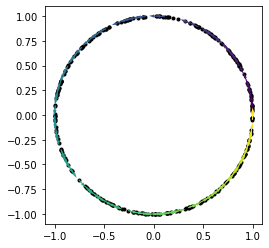

In [ ]:
from directed_graphs.datasets import directed_circle, directed_cylinder, directed_spiral, directed_swiss_roll, directed_spiral_uniform, directed_swiss_roll_uniform
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np
X, flow, labels = directed_circle(num_nodes=300, radius=1)
plot_directed_2d(X, flow, labels)
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0. Loss 150.78147888183594. Flow strength 4.999989986419678. Heatmap of P embedding is 


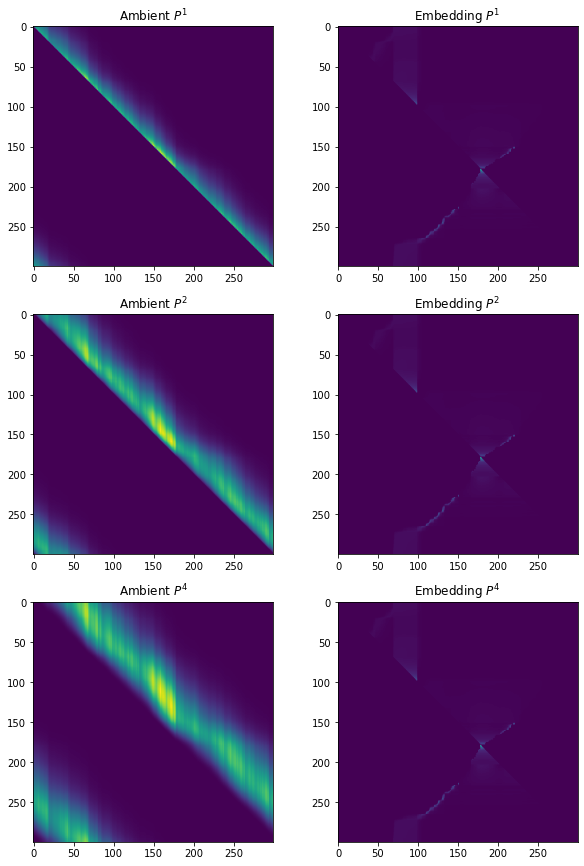

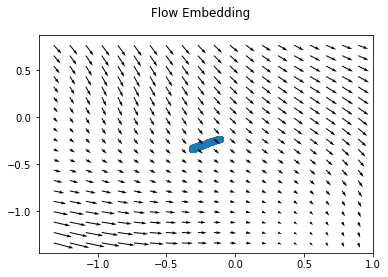

  7%|▋         | 70/1000 [00:47<10:34,  1.47it/s]


KeyboardInterrupt: 

In [ ]:
MFE.fit()